In [1]:
import pickle
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def load_cifar_batch(filename):
    """ 从单个 CIFAR 数据文件加载一个批次的数据 """
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    """ 从所有 CIFAR 文件加载整个数据集 """
    xs = []
    ys = []
    for batch in range(1, 6):
        f = os.path.join(data_dir, f'data_batch_{batch}')
        X, Y = load_cifar_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    X_test, Y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# 指定数据集路径
data_dir = "/Users/oliviagarbo/Documents/Deep learning/assignment 2/cifar-10-batches-py"

# 加载数据
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

# 打印数据形状以验证加载成功
print("训练集图像数据形状:", X_train.shape)
print("训练集标签数据形状:", Y_train.shape)
print("测试集图像数据形状:", X_test.shape)
print("测试集标签数据形状:", Y_test.shape)


训练集图像数据形状: (50000, 3, 32, 32)
训练集标签数据形状: (50000,)
测试集图像数据形状: (10000, 3, 32, 32)
测试集标签数据形状: (10000,)


In [3]:
# 加载数据
# 使用之前的代码加载数据，并预处理
data_dir = "/Users/oliviagarbo/Documents/Deep learning/assignment 2/cifar-10-batches-py"
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

# 数据预处理
X_train = X_train.transpose(0, 2, 3, 1) / 255.0
X_test = X_test.transpose(0, 2, 3, 1) / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1463s 4s/step - accuracy: 0.4249 - loss: 1.6758 - val_accuracy: 0.4442 - val_loss: 1.6620
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1614s 4s/step - accuracy: 0.6811 - loss: 0.8945 - val_accuracy: 0.6997 - val_loss: 0.8610
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1497s 4s/step - accuracy: 0.7808 - loss: 0.6250 - val_accuracy: 0.6375 - val_loss: 1.2256
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1497s 4s/step - accuracy: 0.8369 - loss: 0.4702 - val_accuracy: 0.6638 - val_loss: 1.0624
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1503s 4s/step - accuracy: 0.8742 - loss: 0.3568 - val_accuracy: 0.7321 - val_loss: 0.8314


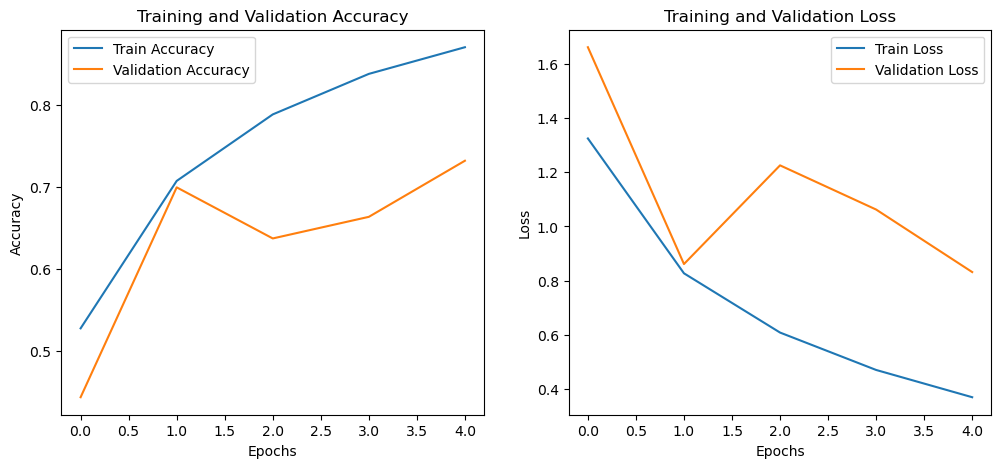

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 构建残差块
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 构建 ResNet-18
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# 加载数据
# 假设之前已使用 load_cifar10() 加载并预处理数据
# X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

# 创建 ResNet-18 模型
model = build_resnet18()

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_data=(X_test, Y_test))

# 绘制准确率和损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
